In [15]:
from libs.pconv_model import PConvUnet
model = PConvUnet(vgg_weights='pytorch_to_keras_vgg16.h5', inference_only=False)
model.load(r'pconv_imagenet.h5', train_bn=False)

In [1]:
import os
from scipy.ndimage import imread
from scipy.misc import imresize
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from PIL import Image
import time
import cv2

In [133]:
imagelist_featname = []
mode = 'RGB'
rootdir = '../data/benchmarkIMAGES'
for subdir, dirs, files in os.walk(rootdir):
    print('here')
    for file in files:
        filename = os.path.basename(file)
        img = imread(subdir + '/' + filename, mode=mode)
        imagelist_featname.append((img,filename))

imagelist_featname = np.array(imagelist_featname)


here


/anaconda2/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


In [ ]:
fixationlist = []
mode = 'RGB'
crop_size = (512,512)
rootdir = '../data/maps/train'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filename = os.path.basename(file)
        if 'train' in filename:
            img = imresize(imread(subdir + '/' + filename, mode=mode), crop_size)
            fixationlist.append(img)
        if len(fixationlist) == 200:
            break

fixationlist = np.array(fixationlist)


In [7]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

feat_model = VGG16(weights='imagenet', include_top=False)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [144]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
base_model = VGG19(weights='imagenet')
low_feat_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)

In [16]:
def get_img_features(img, mask_size, model):
    x = np.array(img, copy=True)
    x = imresize(x, (224,224))
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    gt_feature = = model.predict(x)
    stride = int(mask_size/2)
    features = []
    for i in range(0+stride, 512-(stride*2), stride):
        for j in range(0+stride, 512-(stride*2), stride):
            mask = np.ones((512,512,3))
            mask[i:i+mask_size, j:j+mask_size] = 0
            masked_img = np.array(img, copy=True)
            masked_img = masked_img / 255.0
            masked_img[mask==0] = 1
            masked_img = np.expand_dims(masked_img, axis=0)
            mask = np.expand_dims(mask, axis=0)
            new_img = model.predict([masked_img, mask])
            new_img_mod = imresize(new_img[0], (224,224))
            new_img_mod = np.expand_dims(new_img_mod, axis=0)
            new_img_mod = preprocess_input(new_img_mod)
            feature = model.predict(new_img_mod)
            features.append(feature)
    return gt_feature, features

def get_feat_diff_map(gt_feature, features):
    feat_diff_map = []
    for feature in features:
        value = np.mean(np.absolute(gt_feature-feature))
        feat_diff_map.append(value)
    feat_diff_map = np.asarray(feat_diff_map)
    feat_diff_map = feat_diff_map.reshape((8,8))
    return feat_diff_map
            
        

In [17]:
true_maps = []
for idx, img in enumerate(imagelist):
    shape = img.shape
    img = imresize(img, (512,512))
    gt_feature, features = get_img_features(img, 96)
    feat_diff_map = get_feat_diff_map(gt_feature, features)
    true_map = np.ones((10,10))*np.min(feat_diff_map)
    true_map[1:9, 1:9] = feat_diff_map
    true_map = imresize(true_map, shape, interp='bicubic')
    true_maps.append(true_map)

/anaconda2/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.
/anaconda2/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/anaconda2/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize`

In [145]:
save_array(true_maps, 'save_maps_test')

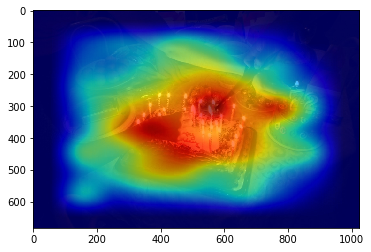

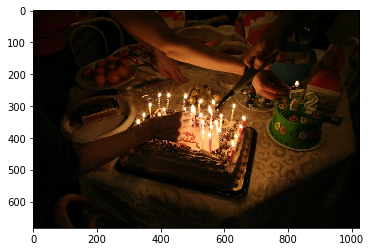

i218.jpg


In [135]:
#30, 35, 38, 222, 1, 2, 4, 6 (text), 8
# bad: 5, 10

img = 94
plt.imshow(imagelist[img])
plt.imshow(true_maps[img], cmap='jet', alpha=0.7)
plt.show()
plt.imshow(imagelist_featname[94][0])
plt.show()
print(imagelist_featname[94][1])

In [136]:
from PIL import Image
for idx, true_map in enumerate(true_maps):
    im = Image.fromarray(true_map)
    filename = imagelist_featname[idx][1]
    im.save('final_maps_high_feat/' + filename)
    


In [141]:
popout_list = []
mode = 'RGB'
rootdir = '../data/popout'
for subdir, dirs, files in os.walk(rootdir):
    print('here')
    for file in files:
        filename = os.path.basename(file)
        img = imread(subdir + '/' + filename, mode=mode)
        popout_list.append(img)

popout_list = np.array(popout_list)


here


/anaconda2/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


In [146]:
def get_error_map(img, mask_size, stride):
    error_map = np.zeros((img.shape))
    prediction_map = np.zeros((img.shape))
    idx = int(512/stride) - 1
    error_values_map = np.zeros((idx, idx))
    pad = int(mask_size/2)
    for i in range(0+pad, 512-pad, stride):
        for j in range(0+pad, 512-pad, stride):
            mask = np.ones((512,512,3))
            mask[i:i+mask_size, j:j+mask_size] = 0
            masked_img = np.array(img, copy=True)
            masked_img[mask==0] = 1
            masked_img = np.expand_dims(masked_img, axis=0)
            mask = np.expand_dims(mask, axis=0)
            new_img = model.predict([masked_img, mask])
            error_map[i:i+mask_size, j:j+mask_size, :] += img[i:i+mask_size, j:j+mask_size, :] - new_img[0, i:i+mask_size, j:j+mask_size, :]
            error_map = np.absolute(error_map)
            prediction_map[i:i+mask_size, j:j+mask_size, :] = new_img[0, i:i+mask_size, j:j+mask_size, :]
            x = int(i/stride)
            y = int(j/stride)
            error_values_map[x, y] = np.sum(np.absolute(img[i:i+mask_size, j:j+mask_size, :] - new_img[0, i:i+mask_size, j:j+mask_size, :]))
    error_map = np.sum(error_map, axis=2)
    return error_map, prediction_map, error_values_map

In [ ]:
import time

img = imagelist[100]
img = img / 255.0
mask = np.ones((512,512, 3))
mask[230:400, 230:400, :] = 0
masked_img = np.array(img, copy=True)
masked_img[mask==0] = 1
plt.imshow(masked_img)
plt.show()
masked_img = np.expand_dims(masked_img, axis=0)
mask = np.expand_dims(mask, axis=0)

In [ ]:
then = time.time()
new_img = model.predict([masked_img,mask])
now = time.time()
print(now-then)
plt.imshow(new_img[0])
plt.show()

In [ ]:
print(img.shape)
print(new_img.shape)
error_map = img[0:32, 0:32, :] - new_img[0, 0:32, 0:32, :]
error_map = np.sum(error_map, axis=2)
plt.imshow(error_map)
plt.show()

In [147]:
error_map, pred_map, error_val = get_error_map(imagelist[4], 96, 96)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 680 but corresponding boolean dimension is 512

In [ ]:
plt.imshow(imagelist[4])
plt.show()
plt.imshow(fixationlist[4])
plt.show()
plt.imshow(error_map)
plt.show()
plt.imshow(pred_map)
plt.show()
plt.imshow(error_val)
plt.show()


In [ ]:
sal_map = imresize(error_val, (512, 512))

In [ ]:
plt.imshow(sal_map)
plt.show()

In [ ]:
error_map_128, pred_map_128, error_val_128 = get_error_map(imagelist[4], 128, 64)

In [ ]:
plt.imshow(imagelist[4])
plt.show()
plt.imshow(fixationlist[4])
plt.show()
plt.imshow(error_map_128)
plt.show()
plt.imshow(pred_map_128)
plt.show()
plt.imshow(error_val_128)
plt.show()

In [ ]:
sal_map_128 = imresize(error_val_128, (512, 512))

In [ ]:
imagelist = []
mode = 'RGB'
crop_size = (224,224)
rootdir = '../data/salicon'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filename = os.path.basename(file)
        if 'train' in filename:
            img = imresize(imread(subdir + '/' + filename, mode=mode), crop_size)
            imagelist.append(img)
        if len(imagelist) == 200:
            break

imagelist = np.array(imagelist)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

x = imagelist[12]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

In [ ]:
print(features.shape)

In [ ]:
plt.imshow(x[0])
plt.show()
plt.imshow(imagelist[12])
plt.show()